# MNIST 손글씨 분류 - 신경망
    - 참고: https://wikidocs.net/62306, https://bcho.tistory.com/1149

In [16]:
import numpy as np
import pandas as pd
import tensorflow as tf
seed = 2022
np.random.seed(seed)
tf.random.set_seed(seed)

### 데이터 전처리

In [17]:
from tensorflow.keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train.shape, X_test.shape, y_train.shape, y_test.shape
# (60000, 28, 28) 어떻게 처리해야 할까? 1건의 데이터가 2차원인 형태
#       신경망, NL => 1차원, CNN => 2차원 

((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

In [18]:
def xx():
    return [(1,2),(3,4)]    # 두 개의 튜플을 담은 리스트

In [19]:
a,b = xx()
a,b

((1, 2), (3, 4))

In [20]:
(a,b),(c,d) = xx()
a,b,c,d

(1, 2, 3, 4)

In [21]:
a,b,c,d = xx()              # Error!

ValueError: ignored

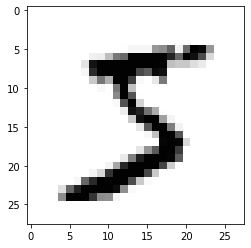

In [22]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0], cmap='Greys')
plt.show()                              # plt.show()없이 plt.imshow(X_train[0], cmap='Greys');를 사용해도 같은 결과

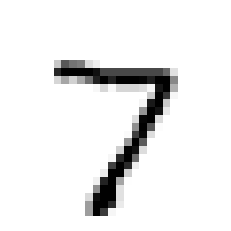

In [23]:
plt.imshow(X_test[0], cmap='Greys'); plt.axis('off');   # 경계선 없이 보고 싶다면 plt.axis('off')

In [24]:
# 어둡기의 정도의 range가 있다. -> 그 중에서 가장 어두운 것이 255, 가장 밝은 것이 0
# Analog data --((Sampling))--> Digital
#   Sampling: 어둠(255)과 밝기(0)의 정도의 range를 정함
# 왜 256일까? 1 byte == 8bit (0 ~ 255 한 바이트에 데이터 하나씩 나눔)
#   cf. Audio (사람의 음성대역, 즉 가청주파수는 20~18000 Hz 사이, 3000Hz 미만이 사람의 음성을 잘 전달 가능)
#       4KHz --((Sampling: 7bit; 128, 56kbps))--> 전화로 목소리를 전달
#   cf. TV --((Sampling: 1px당 (r,g,b) 8*8*8 == 24bit, 60회 FPS; Frame Per Second // 1080*1920 ))--> 영상으로 전달
#       60*24*1080*1920 = 3Gbps (초당 전달하는 횟수)
# 양자화: 연속적으로 보이는 양을 자연수로 셀 수 있는 양으로 재해석하는 것 
#   참고: https://ko.wikipedia.org/wiki/%EC%96%91%EC%9E%90%ED%99%94, http://www.ktword.co.kr/test/view/view.php?m_temp1=911

import sys                              # 원래 이미지 데이터는 0이 어두운 색 ~ 255 밝은색
for row in X_train[0]:                  # 밝은 부분이 0, 근처에 있는 값들이 근사 => 효율적으로 데이터를 압축할 수 있다. 
    for x in row:
        sys.stdout.write(f'{x:3d} ')    # 숫자가 있는 부분이 어두운 색
    sys.stdout.write('\n')

  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136 175  26 166 255 247 127   0   0   0   0 
  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253 225 172 253 242 195  64   0   0   0   0 
  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251  93  82  82  56  39   0   0   0   0   0 
  0   0   0   0   0   0   0  18 219 253 253 253 253 253 198 182 247 241   0   0   0   0   0   0 

In [26]:
type(X_train), X_train.dtype    # uint8: unsigned int (8bit): 0 ~ 255

(numpy.ndarray, dtype('uint8'))

In [27]:
# 0 ~ 1 사이의 값으로 정규화
X_train = X_train / 255.    # 실수라는 것을 보여주기 위해 .을 붙인다.
X_test = X_test / 255.

In [28]:
# 차원 변경: 이미지(2차원) --> 1차원
# 신경망으로 쓰기 위해서는 (28,28)의 차원을 변경해야 한다.
X_train = X_train.reshape(60000, -1)
X_test = X_test.reshape(-1, 784)    # 28 * 28 = 784
X_train.shape, X_test.shape

((60000, 784), (10000, 784))

In [29]:
np.unique(y_train, return_counts=True)  # 0 ~ 9까지의 숫자가 몇 개씩 분포되어있는지 확인

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]))

In [30]:
# One-hot Encoding (다중분류)
# utils 참고: https://keras.io/ko/utils/
from tensorflow.keras.utils import to_categorical
Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)
Y_train.shape, Y_test.shape

((60000, 10), (10000, 10))

- 모델 정의/설정/실행/평가

In [31]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping       # 데이터가 많아질수록, 시간도 많이 걸린다.

In [32]:
model = Sequential([
    Dense(512, input_dim=784, activation='relu'),
    Dense(48, activation='relu'),
    Dense(10, activation='softmax')               # One-Hot Encoding: 10개로 분류 --> 다중분류이기 때문에 activation='softmax'
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               401920    
                                                                 
 dense_1 (Dense)             (None, 48)                24624     
                                                                 
 dense_2 (Dense)             (None, 10)                490       
                                                                 
Total params: 427,034
Trainable params: 427,034
Non-trainable params: 0
_________________________________________________________________


In [33]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
model_path = 'mnist_dnn.h5'         # dnn은 신경망을 의미
checkpoint = ModelCheckpoint(model_path, save_best_only=True, verbose=1)    # monitor는 val_loss가 default
early_stop  = EarlyStopping(patience=10)

In [36]:
hist = model.fit(X_train, Y_train, validation_split=0.2,
             epochs=100, batch_size=200, verbose=0,
             callbacks=[checkpoint, early_stop])


Epoch 00001: val_loss improved from inf to 0.15756, saving model to mnist_dnn.h5

Epoch 00002: val_loss improved from 0.15756 to 0.11145, saving model to mnist_dnn.h5

Epoch 00003: val_loss improved from 0.11145 to 0.09489, saving model to mnist_dnn.h5

Epoch 00004: val_loss improved from 0.09489 to 0.08462, saving model to mnist_dnn.h5

Epoch 00005: val_loss did not improve from 0.08462

Epoch 00006: val_loss improved from 0.08462 to 0.08093, saving model to mnist_dnn.h5

Epoch 00007: val_loss improved from 0.08093 to 0.07590, saving model to mnist_dnn.h5

Epoch 00008: val_loss did not improve from 0.07590

Epoch 00009: val_loss did not improve from 0.07590

Epoch 00010: val_loss did not improve from 0.07590

Epoch 00011: val_loss did not improve from 0.07590

Epoch 00012: val_loss did not improve from 0.07590

Epoch 00013: val_loss did not improve from 0.07590

Epoch 00014: val_loss did not improve from 0.07590

Epoch 00015: val_loss did not improve from 0.07590

Epoch 00016: val_lo

In [37]:
best_model = load_model(model_path)
best_model.evaluate(X_test, Y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.0647 - accuracy: 0.9810


[0.06470876187086105, 0.9810000061988831]

- 학습과정 시각화

In [38]:
y_acc = hist.history['accuracy']
y_vloss = hist.history['val_loss']
xs = np.arange(1, len(y_acc)+1)

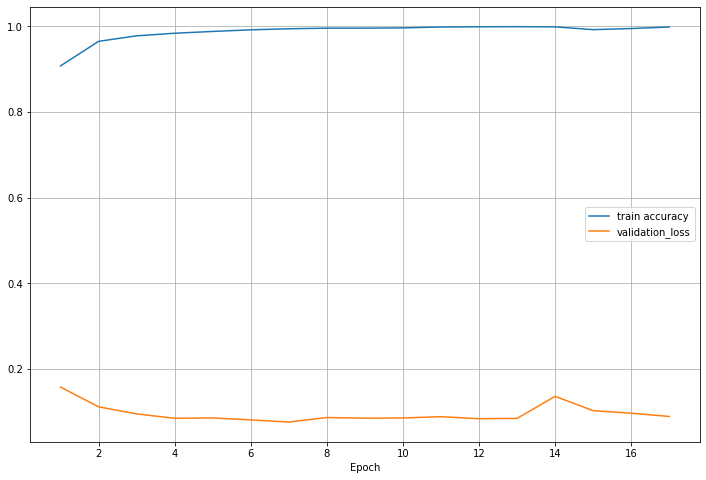

In [40]:
plt.figure(figsize=(12,8))
plt.plot(xs, y_acc, label='train accuracy')
plt.plot(xs, y_vloss, label='validation_loss')
plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.show()